# Read-me

- In this notebook, we load models we optimized and we combined than with VotingClassifier to create a ensemble.
- We used [2,2,1] weights as RandomForests and LGBM are more robust classifiers.
- We also test our ensemble in validation set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split
from lib.utils import *
import pickle

# Load data

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
X_train = np.load('data/input/X_train.npy')
y_train = np.load('data/input/y_train.npy')
X_test = np.load('data/input/X_test.npy')
y_test = np.load('data/input/y_test.npy')

# Test Optimized Models

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

## LGBM

In [5]:
params = pickle.load(open('data/params/lgbm.pickle','rb'))
lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]
    

In [6]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, random_state=0, 
                         class_weight="balanced", n_jobs=-1)

In [10]:
lgbm.fit(X_train,y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.944578432980404,
               learning_rate=0.01909842850485622, max_depth=3,
               min_child_samples=12, n_estimators=528, num_leaves=8,
               random_state=0, subsample=0.6728679300083596)

In [11]:
print_results_model(y_valid, lgbm, X_valid)

Classification report:
              precision    recall  f1-score   support

           0     0.9825    0.9022    0.9406       685
           1     0.6278    0.9113    0.7434       124

    accuracy                         0.9036       809
   macro avg     0.8051    0.9067    0.8420       809
weighted avg     0.9281    0.9036    0.9104       809

ROC AUC Score:
	 0.97
Average precision-recall score:
	 0.5857


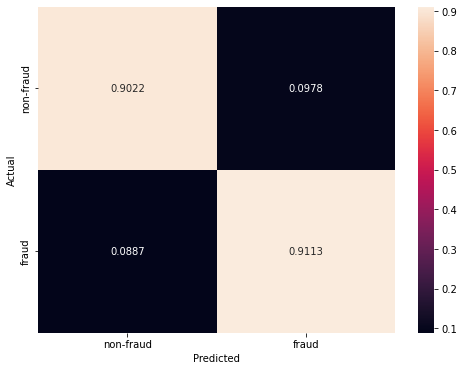

In [12]:
plot_confusion_matrix_model(y_valid, lgbm, X_valid)

## RandomForestClassifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

params = pickle.load(open('data/params/rf.pickle','rb'))

bootstrap = params[0]
max_depth = params[1]
max_features = params[2]
min_samples_leaf = params[3]
min_samples_split = params[4]
n_estimators = params[5]

rf = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, \
 max_features=max_features, min_samples_leaf=min_samples_leaf, \
    min_samples_split=min_samples_split, n_estimators=n_estimators,    \
                             random_state=0, 
                     class_weight="balanced", n_jobs=-1)

In [14]:
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', min_samples_leaf=4,
                       n_estimators=807, n_jobs=-1, random_state=0)

In [16]:
print_results_model(y_valid, rf, X_valid)

Classification report:
              precision    recall  f1-score   support

           0     0.9799    0.9241    0.9512       685
           1     0.6810    0.8952    0.7735       124

    accuracy                         0.9197       809
   macro avg     0.8304    0.9096    0.8623       809
weighted avg     0.9341    0.9197    0.9239       809

ROC AUC Score:
	 0.9683
Average precision-recall score:
	 0.6257


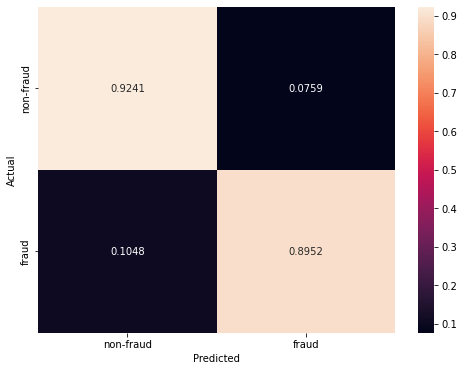

In [17]:
plot_confusion_matrix_model(y_valid, rf, X_valid)

## LogisticRegression

In [18]:
from sklearn.linear_model import LogisticRegression

params = pickle.load(open('data/params/lr.pickle','rb'))

C = params[0]
solver = params[1]

lr = LogisticRegression(C=C, solver=solver,\
                         class_weight="balanced", n_jobs=-1)

In [19]:
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, solver='newton-cg')

In [20]:
print_results_model(y_valid, lr, X_valid)

Classification report:
              precision    recall  f1-score   support

           0     0.9845    0.8321    0.9019       685
           1     0.5000    0.9274    0.6497       124

    accuracy                         0.8467       809
   macro avg     0.7422    0.8798    0.7758       809
weighted avg     0.9102    0.8467    0.8632       809

ROC AUC Score:
	 0.9377
Average precision-recall score:
	 0.4748


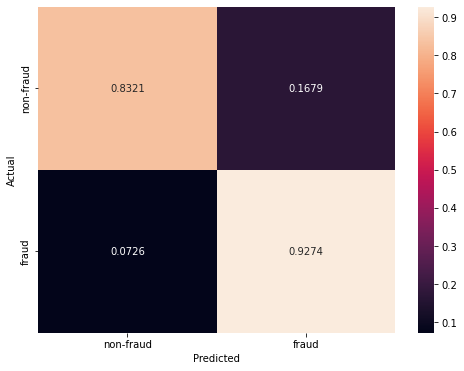

In [23]:
plot_confusion_matrix_model(y_valid, lr, X_valid)

In [24]:
from sklearn.ensemble import VotingClassifier

models = list()
models.append(('lgbm', lgbm))
models.append(('rf', rf))
models.append(('lr', lr))
# define the hard voting ensemble
ensemble = VotingClassifier(estimators=models, voting='soft',weights=[2,2,1])
# fit the model on all available data

In [25]:
import joblib

joblib.dump(ensemble, "./data/models/ensemble.sav")

['./data/models/ensemble.sav']

In [26]:
ensemble.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_freq=1,
                                             class_weight='balanced',
                                             colsample_bytree=0.944578432980404,
                                             learning_rate=0.01909842850485622,
                                             max_depth=3, min_child_samples=12,
                                             n_estimators=528, num_leaves=8,
                                             random_state=0,
                                             subsample=0.6728679300083596)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_leaf=4,
                                               

In [28]:
print_results_model(y_valid, ensemble, X_valid)

Classification report:
              precision    recall  f1-score   support

           0     0.9827    0.9124    0.9463       685
           1     0.6532    0.9113    0.7609       124

    accuracy                         0.9122       809
   macro avg     0.8179    0.9118    0.8536       809
weighted avg     0.9322    0.9122    0.9178       809

ROC AUC Score:
	 0.9668
Average precision-recall score:
	 0.6088


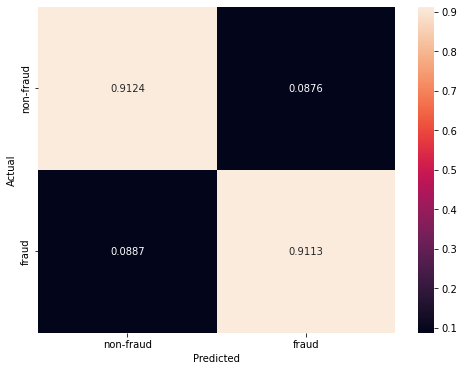

In [30]:
plot_confusion_matrix_model(y_valid, ensemble, X_valid)

In [31]:
y_pred = ensemble.predict_proba(X_test)[:,1]

In [32]:
np.save("data/input/y_pred_ensemble_no_treat.npy",y_pred)